In [13]:
import tensorflow as tf
import numpy as np
import os,math,re,sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #CPU Only

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'#GPU Running

import matplotlib.pylab as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
AUTO = tf.data.experimental.AUTOTUNE
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [14]:
strategy = tf.distribute.MirroredStrategy(devices=None) #Use all available GPUs or CPU
print("REPLICAS:", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
REPLICAS: 1


In [15]:
IMG_SIZE = [311,311]
BATCH_SIZE = 16
EPOCHS = 13

LR_START = 0.00001
LR_MAX = 0.00004 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .7

def scheduler_epoch(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        learning_rate = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        learning_rate = LR_MAX
    else:
        learning_rate = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return learning_rate
                
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler_epoch, verbose=True)

In [16]:
DataSet_Path = '/Users/zhuzhirui/.keras/datasets/104_Flowers'
Train_Size_Choice = {
    192: DataSet_Path + '/jpeg-192x192_train.tfrecord',
    224: DataSet_Path + '/jpeg-224x224_train.tfrecord',
    311: DataSet_Path + '/jpeg-311x311_train.tfrecord',
    512: DataSet_Path + '/jpeg-512x512_train.tfrecord'
}

Val_Size_Choice = {
    192: DataSet_Path + '/jpeg-192x192_val.tfrecord',
    224: DataSet_Path + '/jpeg-224x224_val.tfrecord',
    311: DataSet_Path + '/jpeg-311x311_val.tfrecord',
    512: DataSet_Path + '/jpeg-512x512_val.tfrecord'
}

TrainSet_Path = Train_Size_Choice[IMG_SIZE[0]]
ValSet_Path = Val_Size_Choice[IMG_SIZE[0]]

CLASS = ['toad lily', 'love in the mist', 'monkshood', 'azalea', 'fritillary', 
         'silverbush', 'canterbury bells', 'stemless gentian', 'pink primrose', 'buttercup', 
         'poinsettia', 'desert-rose', 'bird of paradise', 'columbine', 'frangipani', 
         'sweet pea', 'siam tulip', 'great masterwort', 'hard-leaved pocket orchid', 'marigold', 
         'foxglove', 'wild pansy', 'windflower', 'daisy', 'tiger lily', 
         'purple coneflower', 'orange dahlia', 'globe-flower', 'lilac hibiscus', 'fire lily', 
         'balloon flower', 'iris', 'bishop of llandaff', 'yellow iris', 'garden phlox', 
         'alpine sea holly', 'geranium', 'pink quill', 'tree poppy', 'spear thistle', 
         'bromelia', 'common dandelion', 'sword lily', 'peruvian lily', 'carnation', 
         'cosmos', 'spring crocus', 'lotus', 'bolero deep blue', 'anthurium', 
         'rose', 'water lily', 'primula', 'blackberry lily', 'gaura', 
         'trumpet creeper', 'globe thistle', 'sweet william', 'snapdragon', 'mexican petunia', 
         'cyclamen ', 'petunia', 'gazania', 'king protea', 'blanket flower', 
         'common tulip', 'giant white arum lily', 'wild rose', 'morning glory', 'thorn apple', 
         'pincushion flower', 'tree mallow', 'canna lily', 'camellia', 'pink-yellow dahlia', 
         'bee balm', 'wild geranium', 'artichoke', 'black-eyed susan', 'ruby-lipped cattleya', 
         'clematis', 'prince of wales feathers', 'hibiscus', 'cautleya spicata', 'lenten rose', 
         'red ginger', "colt's foot", 'hippeastrum ', 'mallow', 'californian poppy', 
         'corn poppy', 'moon orchid', 'passion flower', 'grape hyacinth', 'japanese anemone', 
         'watercress', 'cape flower', 'osteospermum', 'barberton daisy', 'bougainvillea', 
         'magnolia', 'sunflower', 'daffodil', 'wallflower']

NUM_TRAINING_IMG = 12753
STEPS_PER_EPOCH = NUM_TRAINING_IMG // BATCH_SIZE
NUM_VALIDATION_IMG = 3712
VALIDATION_STEPS = -(-NUM_VALIDATION_IMG // BATCH_SIZE) #The "-(- // )" trick rounds up instead of down


In [17]:
IMG_SIZE_NASNET = [331,331]  
# If you want to finetune NASNet with 'imagenet' weights, input size must be [331,331,3]

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) #JPEG --> Tensor
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.reshape(image, [*IMG_SIZE, 3])
    image = tf.image.resize(image, IMG_SIZE_NASNET) #image must be 3-D, so resize it
    return image

def read_tfrecord(example):
    image_feature_dict = {
        'image': tf.io.FixedLenFeature([],tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_id': tf.io.FixedLenFeature([],tf.string)
    }
    example = tf.io.parse_single_example(example, image_feature_dict) #return a dict
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int64) #104 classes in[0,103]
    image_id = example['image_id'] 
    return image,label   #return a tuple

def load_dataset(filenames, ordered = False):
    ignore_order = tf.data.Options()

    if not ordered:
        ignore_order.deterministic = False # experimental_deterministic has been baned

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TrainSet_Path) #ordered default is False
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) #Prepare later elements
    return dataset

def get_validation_dataset(ordered = False):
    dataset = load_dataset(ValSet_Path, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.cache() #cache files in memory  Might lead to session die
    dataset = dataset.prefetch(AUTO)
    return dataset


In [18]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training label examples:", label.numpy())
labelarray = label.numpy()
print(labelarray[0],type(labelarray[0]))
imagearray = image.numpy()
print(imagearray[0], type(imagearray[0]))

Training data shapes:
(16, 331, 331, 3) (16,)
(16, 331, 331, 3) (16,)
(16, 331, 331, 3) (16,)
Training label examples: [23 30  8 76 33 64 44 21 23 62 73 31 22 31 42 30]
23 <class 'numpy.int64'>
[[[0.9176471  0.82745105 0.1764706 ]
  [0.854902   0.7686275  0.12941177]
  [0.882353   0.80392164 0.18823531]
  ...
  [0.23137257 0.35686275 0.09411766]
  [0.22352943 0.34117648 0.09019608]
  [0.18823531 0.30588236 0.05490196]]

 [[0.86274517 0.7843138  0.20784315]
  [0.82745105 0.74509805 0.1764706 ]
  [0.82745105 0.75294125 0.20784315]
  ...
  [0.227451   0.3529412  0.09019608]
  [0.227451   0.34901962 0.08627451]
  [0.20392159 0.32156864 0.07058824]]

 [[0.7803922  0.7176471  0.28235295]
  [0.7803922  0.7137255  0.2901961 ]
  [0.7411765  0.6745098  0.26666668]
  ...
  [0.19215688 0.31764707 0.05490196]
  [0.18823531 0.3137255  0.0509804 ]
  [0.17254902 0.29803923 0.03529412]]

 ...

 [[0.91372555 0.9294118  0.86274517]
  [0.8588236  0.8745099  0.8078432 ]
  [0.92549026 0.94117653 0.882353  ]

(20, 331, 331, 3) (20,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[ 98  64  23  99  63 101  31   3  56  30  92  39  76  39  14  44  76  61
  77  76]


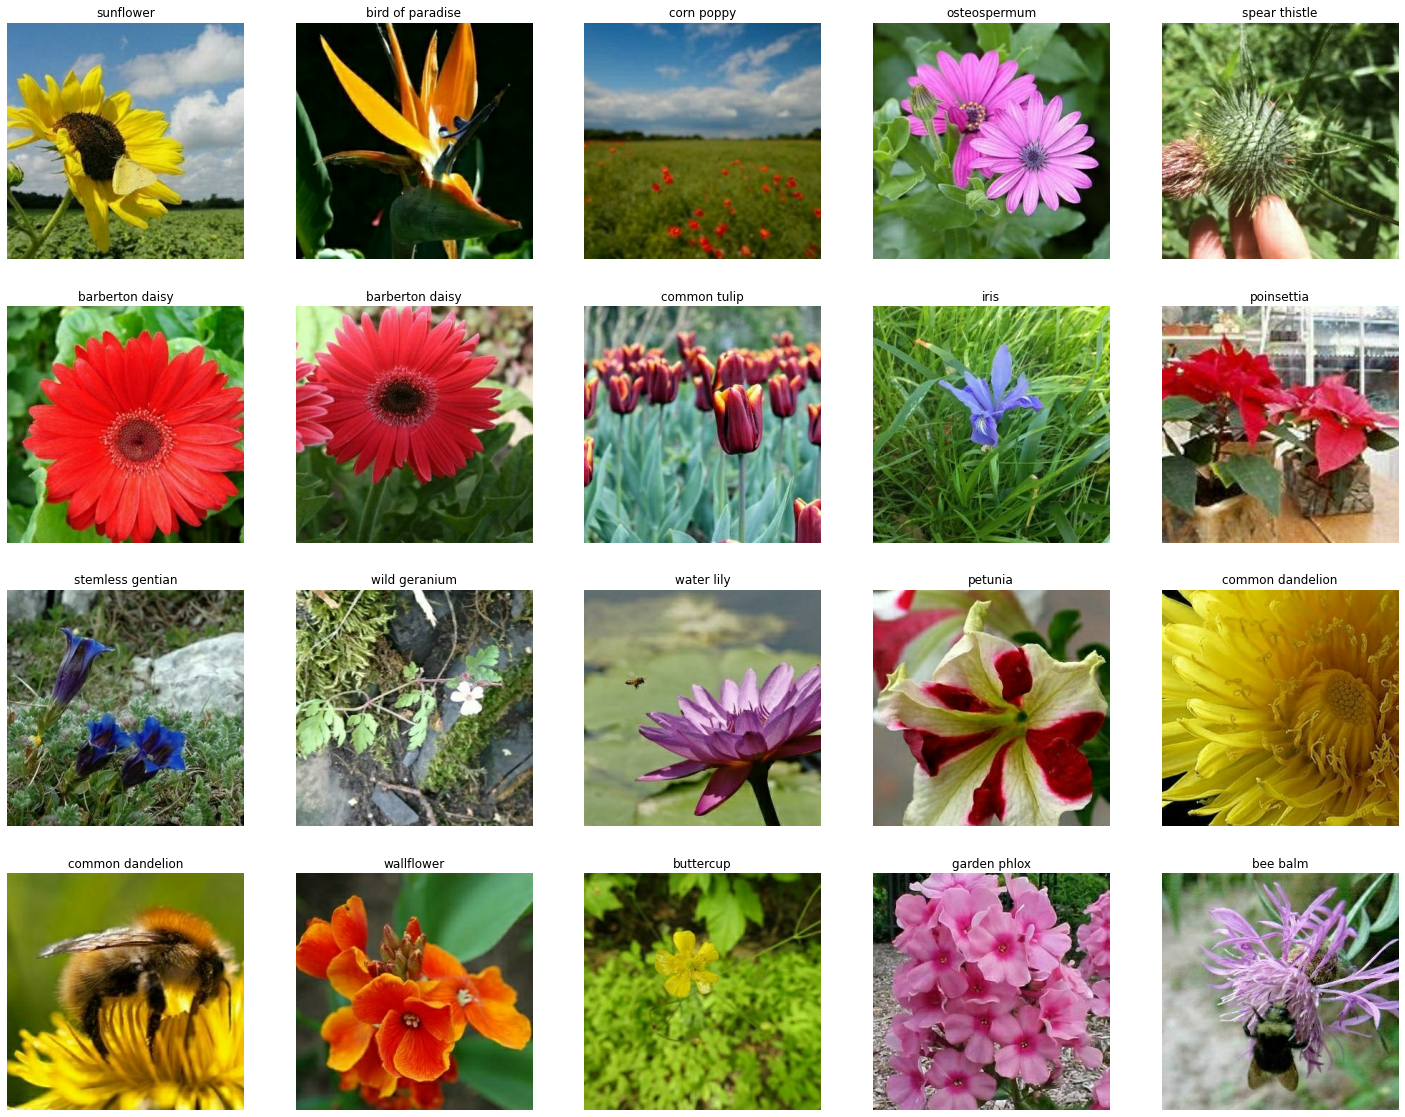

In [19]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20) #20 images, 20 labels in every batch 
train_batch = iter(training_dataset)

for image, label in train_batch:
    print(image.numpy().shape, label.numpy().shape)
    print(type(image.numpy()), type(label.numpy()))
    print(label.numpy())
    break
    
image_batch, label_batch = next(train_batch) # accept the first batch
label_batch = label_batch.numpy()

plt.figure(figsize=(25, 20)) #the size of whole figure
for i in range(20):
  ax = plt.subplot(4, 5, i+1) #the whole figure has 4 rows, 5 columns figures, this is i+1 figure
  #plt.imshow(image_batch[i].numpy().astype("uint8"))  #when image Tensor is the type of Uint8
  plt.imshow(image_batch[i].numpy())
  index = label_batch[i]  #5 classes in[0,4]
  plt.title(CLASS[index])
  plt.axis("off")

(20, 331, 331, 3) (20,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[  3  19   8  26  76 101  24  80  96  51   3  50  49  68  76  88  90  41
  69  76]


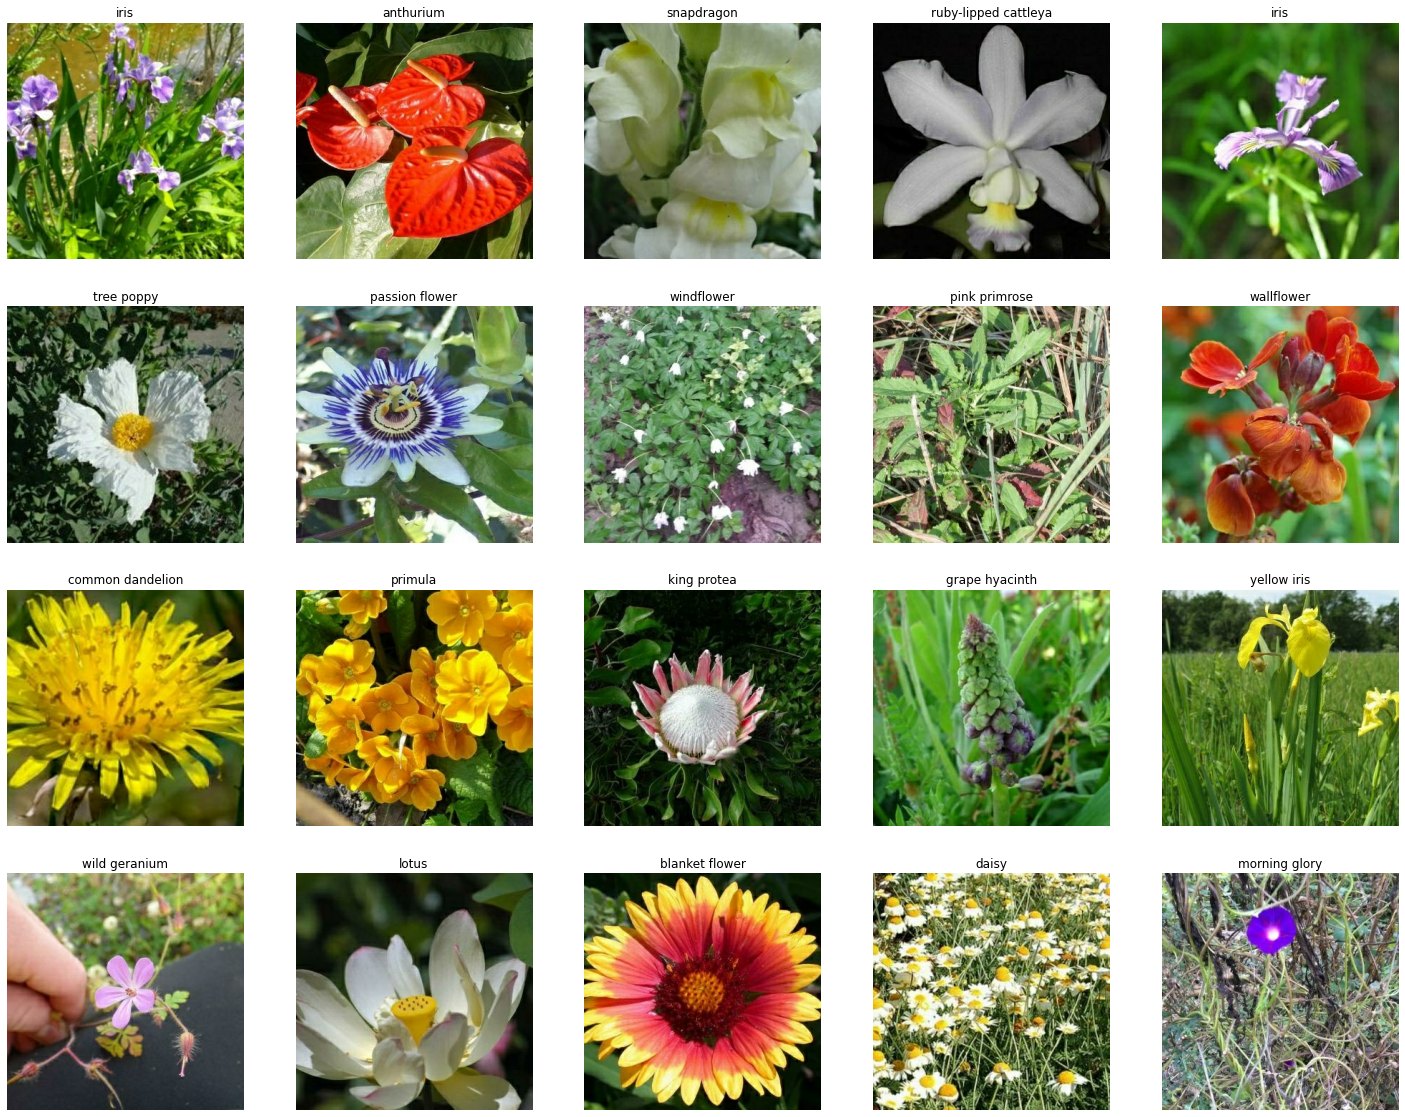

In [20]:
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20) #20 images, 20 labels in every batch 
validation_batch = iter(validation_dataset)

for image, label in validation_batch:
    print(image.numpy().shape, label.numpy().shape)
    print(type(image.numpy()), type(label.numpy()))
    print(label.numpy())
    break
    
image_batch, label_batch = next(validation_batch) # accept the first batch
label_batch = label_batch.numpy()

plt.figure(figsize=(25, 20)) #the size of whole figure
for i in range(20):
  ax = plt.subplot(4, 5, i+1) #the whole figure has 4 rows, 5 columns figures, this is i+1 figure
  #plt.imshow(image_batch[i].numpy().astype("uint8"))  #when image Tensor is the type of Uint8
  plt.imshow(image_batch[i].numpy())
  index = label_batch[i]  #5 classes in[0,4]
  plt.title(CLASS[index])
  plt.axis("off")

In [21]:
with strategy.scope():
    pretrained_model = tf.keras.applications.NASNetLarge(weights='imagenet', include_top=False)
    pretrained_model.trainable = True # fine-tuning
    
    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.nasnet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMG_SIZE_NASNET, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASS), activation='softmax', name='flower_prob')
    ])
    
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=1
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 331, 331, 3)       0         
                                                                 
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 global_average_pooling2d_2   (None, 4032)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flower_prob (Dense)         (None, 104)               419432    
                                                                 
Total params: 85,336,250
Trainable params: 85,139,582
Non-trainable params: 196,668
_________________________________________________________________


In [ ]:
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])

In [22]:
pretrained_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                            

                                                                                                  
 separable_conv_1_pad_reduction  (None, 169, 169, 96  0          ['activation_527[0][0]']         
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activation_529 (Activation)    (None, 83, 83, 42)   0           ['reduction_add_1_stem_1[0][0]'] 
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 83, 83, 42)  168         ['separable_conv_1_reduction_righ
 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable

 add_8 (Add)                    (None, 83, 83, 42)   0           ['reduction_add_2_stem_1[0][0]', 
                                                                  'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 83, 83, 42)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft4_stem_1[0][0]',              
                                                                  'reduction_right5_stem_1[0][0]']
                                                                                                  
 cropping2d_8 (Cropping2D)      (None, 165, 165, 96  0           ['zero_padding2d_8[0][0]']       
                                )                                                                 
                                                                                                  
 reduction

 separable_conv_2_bn_reduction_  (None, 42, 42, 84)  336         ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 89, 89, 84)  0           ['activation_536[0][0]']         
 _right2_stem_2 (ZeroPadding2D)                                                                   
                                                                                                  
 activation_538 (Activation)    (None, 83, 83, 84)   0           ['adjust_bn_stem_2[0][0]']       
                                                                                                  
 reduction_add_1_stem_2 (Add)   (None, 42, 42, 84)   0           ['separable_conv_2_bn_reduction_l
          

                                                                                                  
 separable_conv_2_bn_reduction_  (None, 42, 42, 84)  336         ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 reduction_right5_stem_2 (MaxPo  (None, 42, 42, 84)  0           ['reduction_pad_1_stem_2[0][0]'] 
 oling2D)                                                                                         
                                                                                                  
 zero_padding2d_9 (ZeroPadding2  (None, 84, 84, 168)  0          ['adjust_relu_1_0[0][0]']        
 D)                                                                                               
          

 separable_conv_1_bn_normal_lef  (None, 42, 42, 168)  672        ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 42, 42, 168)  672        ['separable_conv_1_normal_right2_
 ht2_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 42, 42, 168)  672        ['separable_conv_1_normal_left5_0
 t5_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_544 (Activation)    (None, 42, 42, 168)  0           ['separable_conv_1_bn_normal_left
          

 normal_concat_0 (Concatenate)  (None, 42, 42, 1008  0           ['adjust_bn_0[0][0]',            
                                )                                 'normal_add_1_0[0][0]',         
                                                                  'normal_add_2_0[0][0]',         
                                                                  'normal_add_3_0[0][0]',         
                                                                  'normal_add_4_0[0][0]',         
                                                                  'normal_add_5_0[0][0]']         
                                                                                                  
 activation_553 (Activation)    (None, 42, 42, 336)  0           ['reduction_concat_stem_2[0][0]']
                                                                                                  
 activation_554 (Activation)    (None, 42, 42, 1008  0           ['normal_concat_0[0][0]']        
          

                                                                                                  
 separable_conv_2_normal_left2_  (None, 42, 42, 168)  32424      ['activation_560[0][0]']         
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 42, 42, 168)  29736      ['activation_562[0][0]']         
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 42, 42, 168)  29736      ['activation_564[0][0]']         
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable

                                                                                                  
 activation_573 (Activation)    (None, 42, 42, 168)  0           ['adjust_bn_2[0][0]']            
                                                                                                  
 activation_575 (Activation)    (None, 42, 42, 168)  0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 42, 42, 168)  32424      ['activation_567[0][0]']         
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 42, 42, 168)  29736      ['activation_569[0][0]']         
 _2 (SeparableConv2D)                                                                             
          

 normal_right4_2 (AveragePoolin  (None, 42, 42, 168)  0          ['adjust_bn_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 42, 42, 168)  672        ['separable_conv_2_normal_left5_2
 t5_2 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_2 (Add)           (None, 42, 42, 168)  0           ['separable_conv_2_bn_normal_left
                                                                 1_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_2[0][0]']                     
          

                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 42, 42, 168)  672        ['separable_conv_1_normal_right2_
 ht2_3 (BatchNormalization)                                      3[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 42, 42, 168)  672        ['separable_conv_1_normal_left5_3
 t5_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_580 (Activation)    (None, 42, 42, 168)  0           ['separable_conv_1_bn_normal_left
                                                                 1_3[0][0]']                      
                                                                                                  
 activatio

                                                                  'normal_add_2_3[0][0]',         
                                                                  'normal_add_3_3[0][0]',         
                                                                  'normal_add_4_3[0][0]',         
                                                                  'normal_add_5_3[0][0]']         
                                                                                                  
 activation_589 (Activation)    (None, 42, 42, 1008  0           ['normal_concat_2[0][0]']        
                                )                                                                 
                                                                                                  
 activation_590 (Activation)    (None, 42, 42, 1008  0           ['normal_concat_3[0][0]']        
                                )                                                                 
          

 separable_conv_2_normal_left2_  (None, 42, 42, 168)  32424      ['activation_596[0][0]']         
 4 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 42, 42, 168)  29736      ['activation_598[0][0]']         
 _4 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 42, 42, 168)  29736      ['activation_600[0][0]']         
 4 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 42, 42, 168)  672        ['separable_conv_2_normal_left1_4
 t1_4 (Bat

 activation_609 (Activation)    (None, 42, 42, 168)  0           ['adjust_bn_5[0][0]']            
                                                                                                  
 activation_611 (Activation)    (None, 42, 42, 168)  0           ['normal_bn_1_5[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 42, 42, 168)  32424      ['activation_603[0][0]']         
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right1  (None, 42, 42, 168)  29736      ['activation_605[0][0]']         
 _5 (SeparableConv2D)                                                                             
                                                                                                  
 separable

 g2D)                                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 42, 42, 168)  672        ['separable_conv_2_normal_left5_5
 t5_5 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_5 (Add)           (None, 42, 42, 168)  0           ['separable_conv_2_bn_normal_left
                                                                 1_5[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_5[0][0]']                     
                                                                                                  
 normal_ad

 t1_reduce_6 (SeparableConv2D)                                                                    
                                                                                                  
 separable_conv_2_reduction_rig  (None, 21, 21, 336)  129360     ['activation_618[0][0]']         
 ht1_reduce_6 (SeparableConv2D)                                                                   
                                                                                                  
 activation_619 (Activation)    (None, 42, 42, 336)  0           ['adjust_bn_reduce_6[0][0]']     
                                                                                                  
 separable_conv_2_bn_reduction_  (None, 21, 21, 336)  1344       ['separable_conv_2_reduction_left
 left1_reduce_6 (BatchNormaliza                                  1_reduce_6[0][0]']               
 tion)                                                                                            
          

                                )                                                                 
                                                                                                  
 reduction_add_2_reduce_6 (Add)  (None, 21, 21, 336)  0          ['reduction_left2_reduce_6[0][0]'
                                                                 , 'separable_conv_2_bn_reduction_
                                                                 right2_reduce_6[0][0]']          
                                                                                                  
 reduction_left3_reduce_6 (Aver  (None, 21, 21, 336)  0          ['reduction_pad_1_reduce_6[0][0]'
 agePooling2D)                                                   ]                                
                                                                                                  
 separable_conv_2_bn_reduction_  (None, 21, 21, 336)  1344       ['separable_conv_2_reduction_righ
 right3_re

                                                                                                  
 separable_conv_1_normal_right1  (None, 21, 21, 336)  115920     ['activation_628[0][0]']         
 _7 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left2_  (None, 21, 21, 336)  121296     ['activation_630[0][0]']         
 7 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right2  (None, 21, 21, 336)  115920     ['activation_632[0][0]']         
 _7 (SeparableConv2D)                                                                             
                                                                                                  
 separable

                                                                 1_7[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_7[0][0]']                     
                                                                                                  
 normal_add_2_7 (Add)           (None, 21, 21, 336)  0           ['separable_conv_2_bn_normal_left
                                                                 2_7[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_7[0][0]']                     
                                                                                                  
 normal_add_3_7 (Add)           (None, 21, 21, 336)  0           ['normal_left3_7[0][0]',         
          

 activation_639 (Activation)    (None, 21, 21, 336)  0           ['separable_conv_1_bn_normal_left
                                                                 1_8[0][0]']                      
                                                                                                  
 activation_641 (Activation)    (None, 21, 21, 336)  0           ['separable_conv_1_bn_normal_righ
                                                                 t1_8[0][0]']                     
                                                                                                  
 activation_643 (Activation)    (None, 21, 21, 336)  0           ['separable_conv_1_bn_normal_left
                                                                 2_8[0][0]']                      
                                                                                                  
 activation_645 (Activation)    (None, 21, 21, 336)  0           ['separable_conv_1_bn_normal_righ
          

                                                                                                  
 activation_649 (Activation)    (None, 21, 21, 2016  0           ['normal_concat_8[0][0]']        
                                )                                                                 
                                                                                                  
 adjust_conv_projection_9 (Conv  (None, 21, 21, 336)  677376     ['activation_648[0][0]']         
 2D)                                                                                              
                                                                                                  
 normal_conv_1_9 (Conv2D)       (None, 21, 21, 336)  677376      ['activation_649[0][0]']         
                                                                                                  
 adjust_bn_9 (BatchNormalizatio  (None, 21, 21, 336)  1344       ['adjust_conv_projection_9[0][0]'
 n)       

 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 21, 21, 336)  1344       ['separable_conv_2_normal_left1_9
 t1_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 21, 21, 336)  1344       ['separable_conv_2_normal_right1_
 ht1_9 (BatchNormalization)                                      9[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 21, 21, 336)  1344       ['separable_conv_2_normal_left2_9
 t2_9 (BatchNormalization)                                       [0][0]']                         
          

 separable_conv_1_normal_right1  (None, 21, 21, 336)  115920     ['activation_664[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left2_  (None, 21, 21, 336)  121296     ['activation_666[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right2  (None, 21, 21, 336)  115920     ['activation_668[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left5_  (None, 21, 21, 336)  115920     ['activation_670[0][0]']         
 10 (Separ

                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_10[0][0]']                    
                                                                                                  
 normal_add_2_10 (Add)          (None, 21, 21, 336)  0           ['separable_conv_2_bn_normal_left
                                                                 2_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_10[0][0]']                    
                                                                                                  
 normal_add_3_10 (Add)          (None, 21, 21, 336)  0           ['normal_left3_10[0][0]',        
                                                                  'adjust_bn_10[0][0]']           
          

                                                                 1_11[0][0]']                     
                                                                                                  
 activation_677 (Activation)    (None, 21, 21, 336)  0           ['separable_conv_1_bn_normal_righ
                                                                 t1_11[0][0]']                    
                                                                                                  
 activation_679 (Activation)    (None, 21, 21, 336)  0           ['separable_conv_1_bn_normal_left
                                                                 2_11[0][0]']                     
                                                                                                  
 activation_681 (Activation)    (None, 21, 21, 336)  0           ['separable_conv_1_bn_normal_righ
                                                                 t2_11[0][0]']                    
          

 activation_685 (Activation)    (None, 21, 21, 2016  0           ['normal_concat_11[0][0]']       
                                )                                                                 
                                                                                                  
 adjust_conv_projection_12 (Con  (None, 21, 21, 336)  677376     ['activation_684[0][0]']         
 v2D)                                                                                             
                                                                                                  
 normal_conv_1_12 (Conv2D)      (None, 21, 21, 336)  677376      ['activation_685[0][0]']         
                                                                                                  
 adjust_bn_12 (BatchNormalizati  (None, 21, 21, 336)  1344       ['adjust_conv_projection_12[0][0]
 on)                                                             ']                               
          

                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 21, 21, 336)  1344       ['separable_conv_2_normal_left1_1
 t1_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 21, 21, 336)  1344       ['separable_conv_2_normal_right1_
 ht1_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 21, 21, 336)  1344       ['separable_conv_2_normal_left2_1
 t2_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable

 separable_conv_1_reduction_lef  (None, 11, 11, 672)  468384     ['separable_conv_1_pad_reduction_
 t1_reduce_12 (SeparableConv2D)                                  left1_reduce_12[0][0]']          
                                                                                                  
 separable_conv_1_reduction_rig  (None, 11, 11, 672)  484512     ['separable_conv_1_pad_reduction_
 ht1_reduce_12 (SeparableConv2D                                  right1_reduce_12[0][0]']         
 )                                                                                                
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 11, 11, 672)  2688       ['separable_conv_1_reduction_left
 left1_reduce_12 (BatchNormaliz                                  1_reduce_12[0][0]']              
 ation)                                                                                           
          

 oPadding2D)                                                     ]                                
                                                                                                  
 separable_conv_2_reduction_rig  (None, 11, 11, 672)  484512     ['activation_703[0][0]']         
 ht2_reduce_12 (SeparableConv2D                                                                   
 )                                                                                                
                                                                                                  
 activation_705 (Activation)    (None, 11, 11, 672)  0           ['separable_conv_1_bn_reduction_r
                                                                 ight3_reduce_12[0][0]']          
                                                                                                  
 activation_707 (Activation)    (None, 11, 11, 672)  0           ['separable_conv_1_bn_reduction_l
          

 ooling2D)                      )                                                                 
                                                                                                  
 adjust_conv_1_13 (Conv2D)      (None, 11, 11, 336)  677376      ['adjust_avg_pool_1_13[0][0]']   
                                                                                                  
 adjust_conv_2_13 (Conv2D)      (None, 11, 11, 336)  677376      ['adjust_avg_pool_2_13[0][0]']   
                                                                                                  
 activation_708 (Activation)    (None, 11, 11, 2688  0           ['reduction_concat_reduce_12[0][0
                                )                                ]']                              
                                                                                                  
 concatenate_11 (Concatenate)   (None, 11, 11, 672)  0           ['adjust_conv_1_13[0][0]',       
          

                                                                                                  
 separable_conv_2_normal_right2  (None, 11, 11, 672)  457632     ['activation_716[0][0]']         
 _13 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_2_normal_left5_  (None, 11, 11, 672)  457632     ['activation_718[0][0]']         
 13 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 11, 11, 672)  2688       ['separable_conv_2_normal_left1_1
 t1_13 (BatchNormalization)                                      3[0][0]']                        
                                                                                                  
 separable

 activation_729 (Activation)    (None, 11, 11, 672)  0           ['normal_bn_1_14[0][0]']         
                                                                                                  
 separable_conv_1_normal_left1_  (None, 11, 11, 672)  468384     ['activation_721[0][0]']         
 14 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 11, 11, 672)  457632     ['activation_723[0][0]']         
 _14 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left2_  (None, 11, 11, 672)  468384     ['activation_725[0][0]']         
 14 (SeparableConv2D)                                                                             
          

 separable_conv_2_bn_normal_lef  (None, 11, 11, 672)  2688       ['separable_conv_2_normal_left5_1
 t5_14 (BatchNormalization)                                      4[0][0]']                        
                                                                                                  
 normal_add_1_14 (Add)          (None, 11, 11, 672)  0           ['separable_conv_2_bn_normal_left
                                                                 1_14[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_14[0][0]']                    
                                                                                                  
 normal_add_2_14 (Add)          (None, 11, 11, 672)  0           ['separable_conv_2_bn_normal_left
                                                                 2_14[0][0]',                     
          

                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 11, 11, 672)  2688       ['separable_conv_1_normal_left5_1
 t5_15 (BatchNormalization)                                      5[0][0]']                        
                                                                                                  
 activation_734 (Activation)    (None, 11, 11, 672)  0           ['separable_conv_1_bn_normal_left
                                                                 1_15[0][0]']                     
                                                                                                  
 activation_736 (Activation)    (None, 11, 11, 672)  0           ['separable_conv_1_bn_normal_righ
                                                                 t1_15[0][0]']                    
                                                                                                  
 activatio

                                                                  'normal_add_5_15[0][0]']        
                                                                                                  
 activation_743 (Activation)    (None, 11, 11, 4032  0           ['normal_concat_14[0][0]']       
                                )                                                                 
                                                                                                  
 activation_744 (Activation)    (None, 11, 11, 4032  0           ['normal_concat_15[0][0]']       
                                )                                                                 
                                                                                                  
 adjust_conv_projection_16 (Con  (None, 11, 11, 672)  2709504    ['activation_743[0][0]']         
 v2D)                                                                                             
          

 separable_conv_2_normal_right2  (None, 11, 11, 672)  457632     ['activation_752[0][0]']         
 _16 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_2_normal_left5_  (None, 11, 11, 672)  457632     ['activation_754[0][0]']         
 16 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 11, 11, 672)  2688       ['separable_conv_2_normal_left1_1
 t1_16 (BatchNormalization)                                      6[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 11, 11, 672)  2688       ['separable_conv_2_normal_right1_
 ht1_16 (B

                                                                                                  
 separable_conv_1_normal_left1_  (None, 11, 11, 672)  468384     ['activation_757[0][0]']         
 17 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 11, 11, 672)  457632     ['activation_759[0][0]']         
 _17 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left2_  (None, 11, 11, 672)  468384     ['activation_761[0][0]']         
 17 (SeparableConv2D)                                                                             
                                                                                                  
 separable

 t5_17 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 normal_add_1_17 (Add)          (None, 11, 11, 672)  0           ['separable_conv_2_bn_normal_left
                                                                 1_17[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t1_17[0][0]']                    
                                                                                                  
 normal_add_2_17 (Add)          (None, 11, 11, 672)  0           ['separable_conv_2_bn_normal_left
                                                                 2_17[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
          

 separable_conv_1_bn_normal_lef  (None, 11, 11, 672)  2688       ['separable_conv_1_normal_left5_1
 t5_18 (BatchNormalization)                                      8[0][0]']                        
                                                                                                  
 activation_770 (Activation)    (None, 11, 11, 672)  0           ['separable_conv_1_bn_normal_left
                                                                 1_18[0][0]']                     
                                                                                                  
 activation_772 (Activation)    (None, 11, 11, 672)  0           ['separable_conv_1_bn_normal_righ
                                                                 t1_18[0][0]']                    
                                                                                                  
 activation_774 (Activation)    (None, 11, 11, 672)  0           ['separable_conv_1_bn_normal_left
          

                                                                                                  
 activation_779 (Activation)    (None, 11, 11, 4032  0           ['normal_concat_18[0][0]']       
                                )                                                                 
                                                                                                  
Total params: 84,916,818
Trainable params: 84,720,150
Non-trainable params: 196,668
__________________________________________________________________________________________________
